In [1]:
# memory footprint support libraries/code

!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os


In [2]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import gc
import cv2
import matplotlib.pyplot as plt

from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import datetime
from PIL import Image
import warnings
from tqdm.notebook import tqdm
import random
import pandas as pd
import keras
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder


In [3]:
warnings.simplefilter('ignore')
torch.manual_seed(47)
np.random.seed(47)
random.seed(47)
torch.cuda.manual_seed(47)
torch.backends.cudnn.deterministic = True

In [4]:
save_path = "./model_currency.pth"

In [5]:
path = 'F:\A currency dataset\Bd Currency\Custom\Train'
image_path=[]
target=[]
for i in os.listdir(path):
    for j in os.listdir(os.path.join(path,i)):
        image_path.append(os.path.join(path,i,j))
        target.append(i)

In [6]:
table = {'image_path': image_path, 'target': target}
train_df = pd.DataFrame(data=table)
train_df = train_df.sample(frac = 1).reset_index(drop=True) 

In [7]:
path = 'F:\A currency dataset\Bd Currency\Custom\Test'
image_path=[]
target=[]
for i in os.listdir(path):
    for j in os.listdir(os.path.join(path,i)):
        image_path.append(os.path.join(path,i,j))
        target.append(i)

In [8]:
table = {'image_path': image_path, 'target': target}
test_df = pd.DataFrame(data=table)
test_df = test_df.sample(frac = 1).reset_index(drop=True) 

In [9]:
train_df.head()

,image_path,target
0,F:\A currency dataset\Bd Currency\Custom\Train...,ten
1,F:\A currency dataset\Bd Currency\Custom\Train...,5hundred
2,F:\A currency dataset\Bd Currency\Custom\Train...,fifty
3,F:\A currency dataset\Bd Currency\Custom\Train...,5hundred
4,F:\A currency dataset\Bd Currency\Custom\Train...,5hundred


In [12]:
train_df.isnull().sum()

image_path    0
target        0
dtype: int64

In [17]:
train_df.isnull().sum()

image_path    0
target        0
dtype: int64

In [18]:
test_df.isnull().sum()

image_path    0
target        0
dtype: int64

In [19]:
print(np.isfinite(train_df['target']).all())
print(np.isfinite(test_df['target']).all())


True
True


In [20]:
train_df = train_df.dropna(subset=['target'])
test_df = test_df.dropna(subset=['target'])


In [21]:
train_df['target'] = train_df['target'].fillna(0)
test_df['target'] = test_df['target'].fillna(0)


In [22]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df['target'] = train_df['target'].fillna(0)
test_df['target'] = test_df['target'].fillna(0)


In [23]:
label_mapping = {"5Hundred": 0,
                "1Hundred": 1,
                "2Hundred": 2,
                "Ten": 3,
                "Fifty": 4,
                "Twenty": 5,
                "1Thousands": 6}
train_df['target'] = train_df['target'].map(label_mapping).astype(int)
test_df['target'] = test_df['target'].map(label_mapping).astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [27]:
from sklearn.preprocessing import LabelEncoder
label_mapping = {"5Hundred": 0,
                "1Hundred": 1,
                "2Hundred": 2,
                "Ten": 3,
                "Fifty": 4,
                "Twenty": 5,
                "1Thousands": 6}
le = LabelEncoder()
train_df['target'] = le.fit_transform(train_df['target'])
test_df['target'] = le.fit_transform(test_df['target'])

Text(0, 0.5, 'samples')

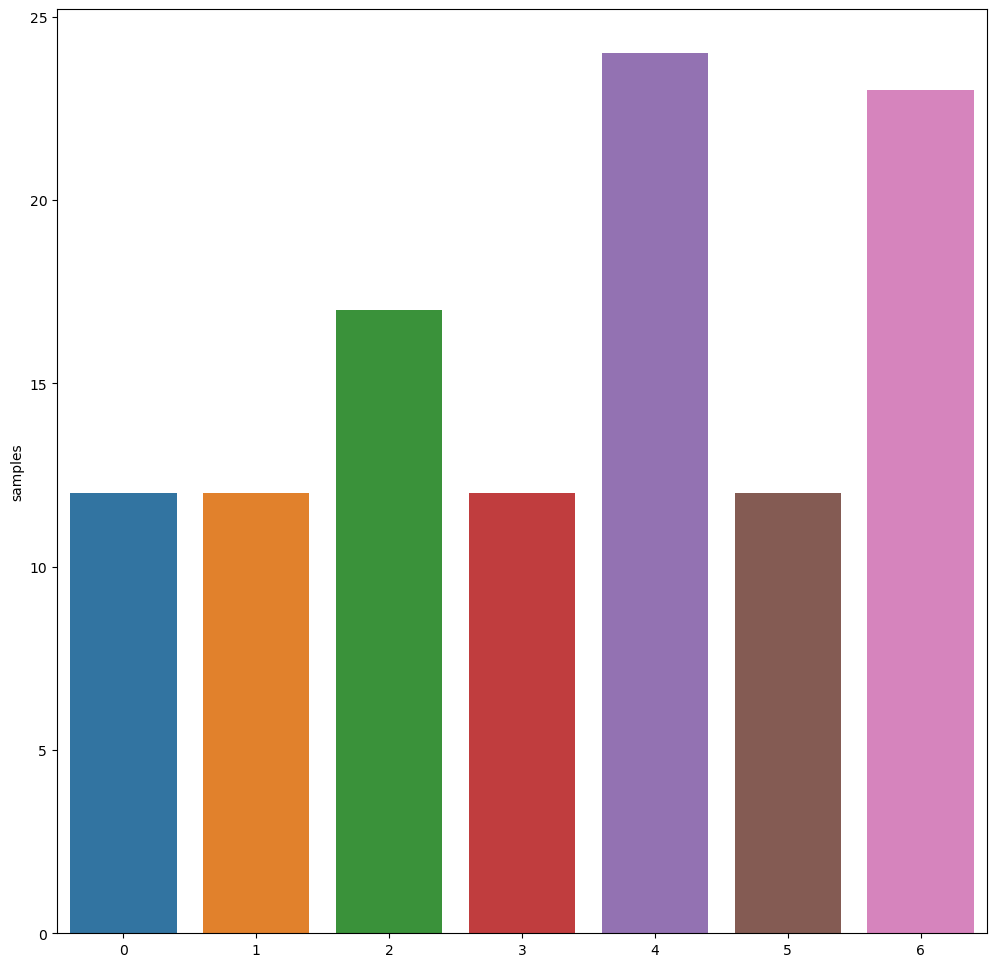

In [28]:
plt.figure(figsize=(12,12))
x=test_df.target.value_counts()
sns.barplot(x = x.index,y = x)
plt.gca().set_ylabel('samples')

In [29]:
class CustomDataset(Dataset):
    def __init__(self,dataframe,transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return self.dataframe.shape[0]
    def __getitem__(self,index):
        image = self.dataframe.iloc[index]['image_path']
        image = cv2.imread(image)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = int(self.dataframe.iloc[index]["target"])
        return {"image": torch.tensor(image, dtype=torch.float), "targets": torch.tensor(label, dtype = torch.long)}

In [30]:
def get_model(classes=7):
    model = models.resnet50(pretrained=True)
    features = model.fc.in_features
    model.fc = nn.Linear(in_features = features, out_features = classes)
    return model

In [31]:
from torchvision import transforms,datasets,models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
model = get_model()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [33]:
optimizer  = optim.Adam(model.parameters(),lr = 0.00003)
loss_function = nn.CrossEntropyLoss()
train_dataset = CustomDataset(
dataframe=train_df,
transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 4)
valid_dataset = CustomDataset(
dataframe=test_df,
transform=test_transform)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
best_accuracy = 0

In [ ]:
from torch.utils.data import DataLoader

# ... (your previous code)

# Modify the DataLoader creation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

# ... (your previous code)

best_accuracy = 0

for epoch in tqdm(range(15), desc="Epochs"):
    model.train()

    for data_in_model in tqdm(train_loader, desc="Training"):
        inputs = data_in_model['image']
        targets = data_in_model['targets']

        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    final_targets = []
    final_outputs = []
    val_loss = 0

    with torch.no_grad():
        for data_in_model in tqdm(valid_loader, desc="Evaluating"):
            inputs = data_in_model['image']
            targets = data_in_model['targets']

            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.long)

            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()
            _, predictions = torch.max(outputs, 1)

            targets = targets.cpu().numpy().tolist()
            predictions = predictions.cpu().numpy().tolist()

            final_targets.extend(targets)
            final_outputs.extend(predictions)

    acc = (np.array(final_outputs) == np.array(final_targets)).mean() * 100

    if acc > best_accuracy:
        best_accuracy = acc
        torch.save(model.state_dict(), save_path)

    print("EPOCH: {}/15".format(epoch + 1))
    print("ACCURACY: {:.2f}%".format(acc))
    print("LOSS: {:.4f}".format(val_loss))


Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH: 1/15
ACCURACY: 100.00%
LOSS: 0.4349


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH: 2/15
ACCURACY: 100.00%
LOSS: 0.0576


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

EPOCH: 3/15
ACCURACY: 100.00%
LOSS: 0.0255


Training:   0%|          | 0/80 [00:00<?, ?it/s]